## DDQN in Hockey Enviroment - Training

Train a DDQN on various Hockey env. modes

Base DQN implementation adapted from HW7

In [69]:
from importlib import reload
from typing import Iterable

import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import DDQN.DDQN as ddqn
from DDQN.DDQN import DDQNAgent
import hockey.hockey_env as h_env

In [70]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Training

In [71]:
class Round:
    """
    A class to represent a sequence of opponents to train against
    """

    def __init__(self, max_steps, agent_opp):
        self.max_steps = max_steps
        self.agent_opp = agent_opp


class Stats:
    """
    A class to represent the statistics of the training process
    """

    def __init__(self, returns, returns_ts, losses, losses_ts):
        self.returns = returns
        self.returns_training_stages = returns_ts
        self.losses = losses
        self.losses_training_stages = losses_ts


def train_agent(agent: DDQNAgent, env: h_env.HockeyEnv, max_ep: int, rounds: Iterable[Round],
                stats: Stats, ddqn_iter_fit=32, print_freq=25, verbose=False):
    """
    Train the agent in the hockey environment

    Parameters:
    agent: the agent to train
    env: the environment to train in
    max_ep: the maximum number of episodes to train for
    rounds: describing the sequence of opponents to train against
    stats: object to store the statistics of the training process
    ddqn_iter_fit: the number of iterations to train the DDQN agent for
    print_freq: how often to print the current episode statistics
    """
    
    # TODO: env.reset supports changing modes, support different modes in this function. Randomly select mode?

    for j, r in enumerate(rounds):
        max_steps = r.max_steps
        agent_opp = r.agent_opp
        if verbose:
            print(f"Begin round {j+1} for {max_ep} episodes")

        stats.losses_training_stages.append(len(stats.losses))
        stats.returns_training_stages.append(len(stats.returns))

        for i in tqdm(range(max_ep)):
            total_reward = 0
            ob_a1, _info = env.reset()
            ob_a2 = env.obs_agent_two()

            for t in range(max_steps):
                done = False
                trunc = False

                a1_discr = agent.act(ob_a1)
                a1 = env.discrete_to_continous_action(a1_discr)
                a2 = agent_opp.act(ob_a2)

                ob_a1_next, reward, done, trunc, _info = env.step(
                    np.hstack([a1, a2])
                )
                total_reward += reward

                agent.store_transition(
                    (ob_a1, a1_discr, reward, ob_a1_next, done)
                )

                ob_a1 = ob_a1_next
                ob_a2 = env.obs_agent_two()

                if done or trunc:
                    break
            
            loss = agent.train(ddqn_iter_fit)

            stats.losses.extend(loss)
            stats.returns.append([i, total_reward, t+1])

            if verbose and (i % print_freq == 0 or i == max_ep - 1):
                print(f"Episode {i+1} | Return: {total_reward} | Loss: {loss[-1]} | Done in {t+1} steps")

### Environment & Agent Initialization

In [72]:
reload(h_env)

env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [76]:
DISCOUNT = 0.90
EPS = 0.2
UPDATE_TARGET_FREQ = 20
TAU = 1e-3

agent_player = DDQNAgent(
    env.observation_space,
    env.discrete_action_space,
    discount=DISCOUNT,
    epsilon=EPS,
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU
)

agent_opp_weak = h_env.BasicOpponent(weak=True)
agent_opp_strong = h_env.BasicOpponent(weak=False)

In [77]:
# For the visualisation of the training progress

stats = Stats(
    returns=[],
    returns_ts=[],
    losses=[],
    losses_ts=[]
)

### Training

In [78]:
rounds = [
    Round(1000, agent_opp_weak),
    Round(1000, agent_opp_strong)
]

train_agent(
    agent_player,
    env,
    max_ep=500,
    rounds=rounds,
    stats=stats,
    ddqn_iter_fit=64,
    print_freq=100,
    verbose=True
)

Begin round 1 for 500 episodes


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 1 | Return: -11.306105324578677 | Loss: 0.21353812515735626 | Done in 44 steps
Episode 101 | Return: -12.373399811823674 | Loss: 0.0033126005437225103 | Done in 81 steps
Episode 201 | Return: 9.138038124911724 | Loss: 0.003714647376909852 | Done in 98 steps
Episode 301 | Return: -11.031149641582795 | Loss: 0.0043150391429662704 | Done in 50 steps
Episode 401 | Return: -14.290298115165562 | Loss: 0.006190217100083828 | Done in 88 steps
Episode 500 | Return: -6.746119815275765 | Loss: 0.04062547907233238 | Done in 251 steps
Begin round 2 for 500 episodes


  0%|          | 0/500 [00:00<?, ?it/s]

Episode 1 | Return: -7.43786999476986 | Loss: 0.033487431704998016 | Done in 251 steps
Episode 101 | Return: 3.3246282795206366 | Loss: 0.0058607300743460655 | Done in 233 steps
Episode 201 | Return: 5.590941411801954 | Loss: 0.15308091044425964 | Done in 140 steps
Episode 301 | Return: -26.083652479112505 | Loss: 0.03469494730234146 | Done in 251 steps
Episode 401 | Return: -13.856808881482772 | Loss: 0.011095835827291012 | Done in 96 steps
Episode 500 | Return: -14.550214288294166 | Loss: 0.05713741108775139 | Done in 251 steps


## Agent Model Saving

In [81]:
STATE_PATH = "./DDQN/models/hockey_normal_dev/"

reload(ddqn)

agent_player.save_state(STATE_PATH)

## Visualization

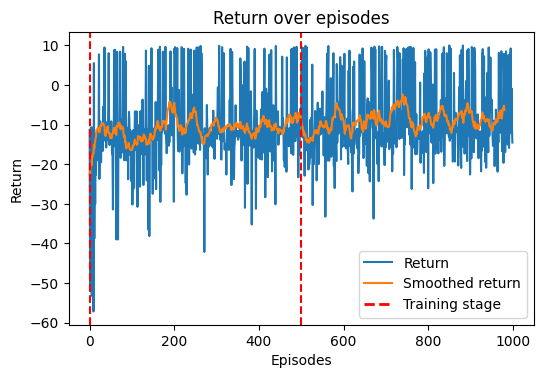

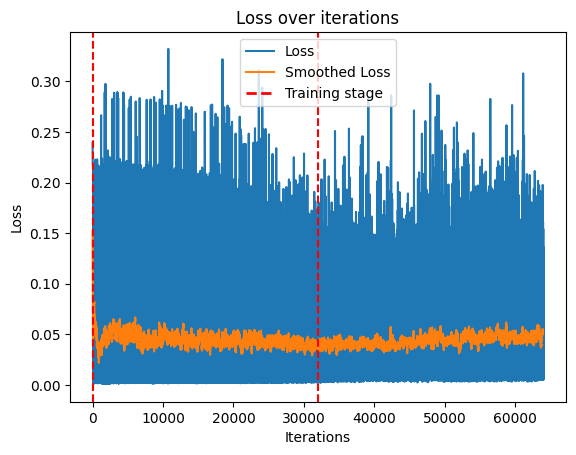

In [82]:
from matplotlib.lines import Line2D

returns_np = np.asarray(stats.returns)
losses_np = np.asarray(stats.losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(returns_np[:,1], label="Return")
plt.plot(running_mean(returns_np[:,1],20), label="Smoothed return")
for xc in stats.returns_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Return over episodes")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

plt.figure()
plt.plot(losses_np, label="Loss")
plt.plot(running_mean(losses_np, 100), label="Smoothed Loss")
for xc in stats.losses_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

### Rendered Demonstration Against Strong Opponent

For a more detailed evaluation, refer to `ddqn-hockey-eval.ipynb`.

In [83]:
STEPS = 100000

obs_buffer = []
reward_buffer = []
obs, _ = env.reset()
obs_agent2 = env.obs_agent_two()

for i in range(STEPS):
    env.render()
    a1_discr = agent_player.act(obs)
    a1 = env.discrete_to_continous_action(a1_discr)
    a2 = agent_opp_strong.act(obs_agent2)

    obs, r, done, trunc, _ = env.step(np.hstack([a1, a2]))
    obs_buffer.append(obs)
    reward_buffer.append(r)

    obs_agent2 = env.obs_agent_two()

    if done or trunc:
        print(f"Episode done in {i} steps")
        break


Episode done in 77 steps


In [84]:
env.close()